In [3]:
!pip install pytorch-lightning
!pip install transformers

In [7]:
!pip install datasets
import datasets

In [36]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F
from torch.jit import script, trace
from torch import optim
import matplotlib.pyplot as plt
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AdamW
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

pl.seed_everything(100)
import nltk
import itertools

# Processing data

In [10]:
import re
def normalizeString(s):
    s = s.lower().strip() # chuyển tất cả kí tự thành chữ thường và loại bỏ khoảng trắng đầu cuối
    # s = re.sub(r"([.!?])", r" \1", s) # thêm khoảng trắng trước dấu câu
    s = re.sub(r"[^a-zA-ZÀ-ỹ\d.!?]+", r" ", s) # xóa các kí tự đặc biệt và số
    s = re.sub(r"\s+", r" ", s).strip() # xóa khoảng trắng thừa
    return s

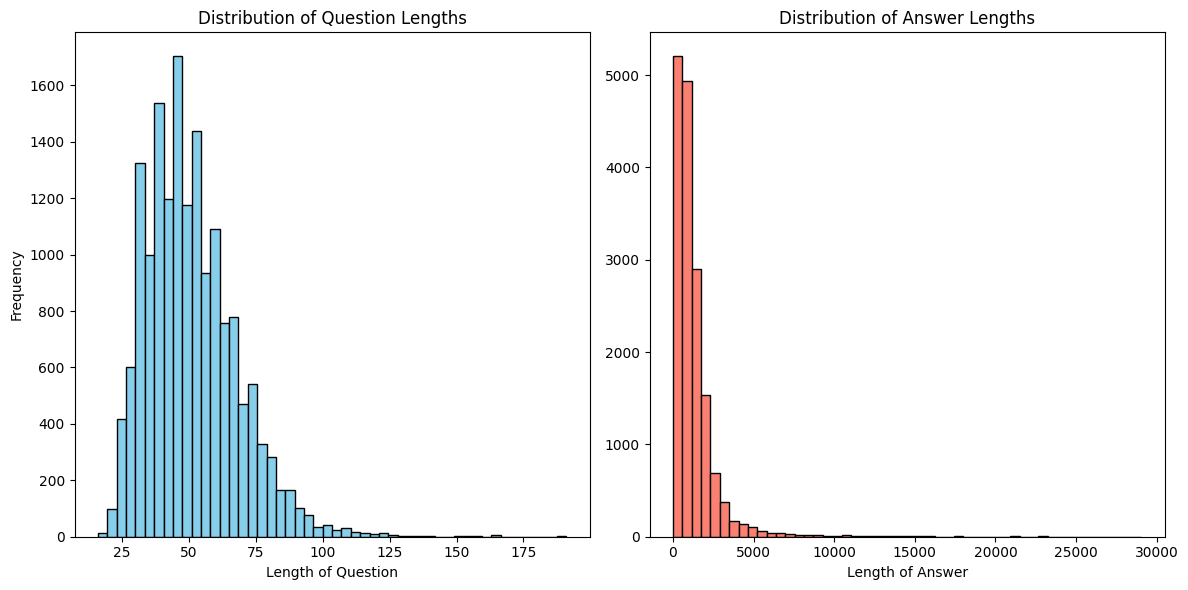

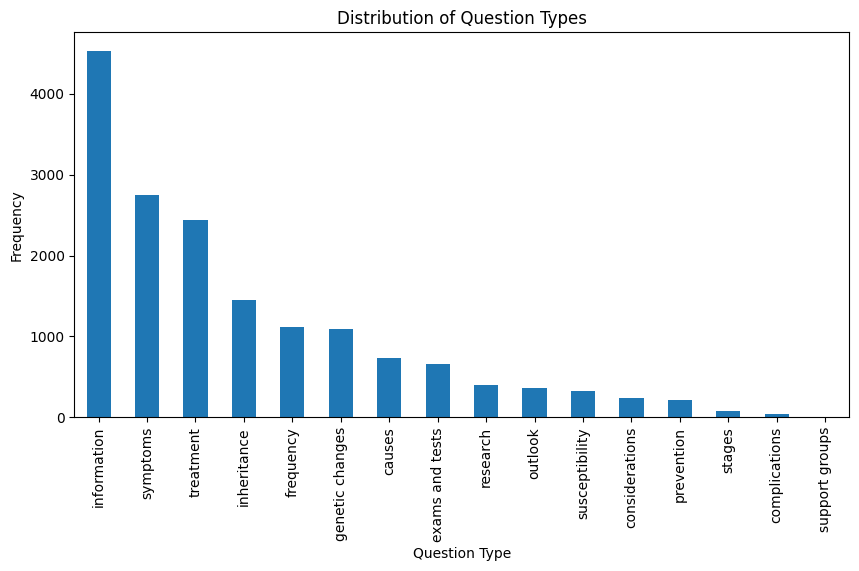

Total number of rows in the dataset: 16407
Number of tokens in the longest question: 27
Number of tokens in the shortest question: 3
Number of tokens in the longest answer: 4281
Number of tokens in the shortest answer: 1


In [48]:

# Load the dataset
dataset = datasets.load_dataset("keivalya/MedQuad-MedicalQnADataset")
data = pd.DataFrame(dataset["train"])

# Calculate the length of questions and answers
data['question_length'] = data['Question'].apply(len)
data['answer_length'] = data['Answer'].apply(len)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the distribution of question lengths
axes[0].hist(data['question_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Question Lengths')
axes[0].set_xlabel('Length of Question')
axes[0].set_ylabel('Frequency')

# Plot the distribution of answer lengths
axes[1].hist(data['answer_length'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Answer Lengths')
axes[1].set_xlabel('Length of Answer')

# Display the plots
plt.tight_layout()
plt.show()

# Vẽ biểu đồ phân phối số lượng câu hỏi theo chủ đề
plt.figure(figsize=(10, 5))
data['qtype'].value_counts().plot(kind='bar')
plt.title('Distribution of Question Types')
plt.xlabel('Question Type')
plt.ylabel('Frequency')
plt.show()

# In ra số dòng của dataset
print(f"Total number of rows in the dataset: {len(data)}")

# Tính số token của câu dài nhất và ngắn nhất
token_lengths = data['Question'].apply(lambda x: len(x.split()))
max_length = max(token_lengths)
min_length = min(token_lengths)

# In ra số token của câu dài nhất và ngắn nhất
print(f"Number of tokens in the longest question: {max_length}")
print(f"Number of tokens in the shortest question: {min_length}")

# Tính số token của câu trả lời dài nhất và ngắn nhất
answer_token_lengths = data['Answer'].apply(lambda x: len(x.split()))
max_answer_length = max(answer_token_lengths)
min_answer_length = min(answer_token_lengths)

# In ra số token của câu trả lời dài nhất và ngắn nhất
print(f"Number of tokens in the longest answer: {max_answer_length}")
print(f"Number of tokens in the shortest answer: {min_answer_length}")


In [46]:
data = dataset["train"]
lines = [example["Question"]+ "\t" + example["Answer"] for example in data]
pairs = [(normalizeString(example["Question"]), normalizeString(example["Answer"])) for example in data]
train_pairs, test_pairs = train_test_split(pairs, test_size=0.3, random_state=42)
print(pairs[0])

('who is at risk for lymphocytic choriomeningitis lcm ? ?', 'lcmv infections can occur after exposure to fresh urine droppings saliva or nesting materials from infected rodents. transmission may also occur when these materials are directly introduced into broken skin the nose the eyes or the mouth or presumably via the bite of an infected rodent. person to person transmission has not been reported with the exception of vertical transmission from infected mother to fetus and rarely through organ transplantation.')


In [17]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_len = 128
batch_size = 32 # batch size of training
epoch = 4 # number of epoch

In [20]:
class Dataset:

  def __init__(self,pairs):

    self.pairs = pairs
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self,item):             # This method retrieves the item at the specified index item.

    question = self.pairs[item][0]

    answer = self.pairs[item][1]

    input_tokenize = self.tokenizer(
            question,
            add_special_tokens=True,
            max_length=self.max_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors="pt"
        )
    output_tokenize = self.tokenizer(
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors="pt"

        )


    input_ids = input_tokenize["input_ids"].flatten()
    attention_mask = input_tokenize["attention_mask"].flatten()
    labels = output_tokenize['input_ids'].flatten()

    out = {
            'question':question,
            'answer':answer,
            'input_ids': input_ids,
            'attention_mask':attention_mask,
            'target':labels
        }

    return out
train_data = Dataset(train_pairs)
test_data = Dataset(test_pairs)
print((train_data[500]))
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size = 32,
                                            shuffle=False,
                                            num_workers=3)
test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size = 32,
                                            shuffle=False,
                                            num_workers=3)


{'question': 'what is the outlook for endometrial cancer ?', 'answer': 'certain factors affect prognosis chance of recovery and treatment options.the prognosis chance of recovery and treatment options depend on the following the stage of the cancer whether it is in the endometrium only involves the uterus wall or has spread to other places in the body . how the cancer cells look under a microscope. whether the cancer cells are affected by progesterone. endometrial cancer can usually be cured because it is usually diagnosed early.', 'input_ids': tensor([  125,    19,     8, 16395,    21,   414,    32,  8180,   138,  1874,
            3,    58,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

In [22]:
class T5Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)


    def forward(self, input_ids, attention_mask, labels=None):

        output = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
        )
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels= batch["target"]
        loss, logits = self(input_ids , attention_mask, labels)


        self.log("train_loss", loss, prog_bar=True, logger=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels= batch["target"]
        loss, logits = self(input_ids, attention_mask, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)

        return {'val_loss': loss}

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

# Final Training Step

In [23]:
# Initialize your model
model = T5Model()
model.to(device)
def run():
    # Define a checkpoint callback
    checkpoint = ModelCheckpoint(
        dirpath="/kaggle/working",
        filename='best-model',
        save_top_k=2,
        verbose=True,
        monitor="val_loss",
        mode="min"
    )

    # Initialize the Trainer with the checkpoint callback
    trainer = pl.Trainer(
        callbacks=checkpoint,
        max_epochs=epoch,
        accelerator="gpu" if torch.cuda.is_available() else 'cpu',
        # devices=[0]
    )

    # Fit the model using the training and validation dataloaders
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

# Call the run function to start training
run()

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

2024-05-20 10:38:49.141396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 10:38:49.141492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 10:38:49.416191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [30]:
train_model = T5Model.load_from_checkpoint('/kaggle/working/best-model.ckpt')
train_model.freeze()

def generate_question(question):
    """
    Hàm tạo câu hỏi sử dụng mô hình T5.

    Args:
        question (str): Câu hỏi gốc.

    Returns:
        str: Câu hỏi được tạo.
    """

    # Tokenize câu hỏi
    inputs = tokenizer(
        question,
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    ).to(device)

    # Tạo câu hỏi
    outputs = train_model.model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_len,
        num_beams=4,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    # Decode câu hỏi
    question = tokenizer.decode(
        outputs[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    return question

# Model Evaluation

In [37]:
def calculate_bleu4(reference, hypothesis):
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    weights = (0.25, 0.25, 0.25, 0.25)  # BLEU-4 weights
    bleu_score = nltk.translate.bleu_score.sentence_bleu([reference_tokens], hypothesis_tokens, weights=weights)

    return bleu_score

In [50]:
for i in range(10,13):
    question = test_pairs[i][0]
    reference = test_pairs[i][1]
    generated_question = generate_question(question)

    bleu4_score = calculate_bleu4(reference, generated_question)
    print(" - Question:", question)
    print(" - Reference:", reference)
    print(" - Generated answer:", generated_question)
    print(" - BLEU-4 Score:", bleu4_score)
    print("=====")

 - Question: what is yersiniosis for yersinia ?
 - Reference: yersiniosis is an infectious disease caused by a bacterium of the genus yersinia. in the united states most human illness is caused by one species y. enterocolitica. infection with y. enterocolitica can cause a variety of symptoms depending on the age of the person infected. infection with y. enterocolitica occurs most often in young children. common symptoms in children are fever abdominal pain and diarrhea which is often bloody. symptoms typically develop 4 to 7 days after exposure and may last 1 to 3 weeks or longer. in older children and adults right sided abdominal pain and fever may be the predominant symptoms and may be confused with appendicitis. in a small proportion of cases complications such as skin rash joint pains or spread of bacteria to the bloodstream can occur.
 - Generated answer: yersiniosis is a condition that affects the nervous system. signs and symptoms of this
 - BLEU-4 Score: 0.00011351413811323313


In [31]:
ques = "I got headache. what should i do ?"
print("Ask: ",ques)
print("Answer: ",generate_question(ques))

Ques:  I got headache. what should i do ?
BOT:  i have a headache. if you re in pain you should talk with your health care provider right away. this is the best thing you can do to relieve the pain.


In [33]:
ques = test_pairs[0][0]
sample_ans = test_pairs[0][1]
print("Ask: ",ques)
print("Answer: ",generate_question(ques))

Ask:  How to prevent Q Fever ?
Answer:  you can t prevent Q Fever if you have a family history of the disease. you ll want to talk with your health care provider about how to prevent it.


In [35]:
ques = "What are the symptoms of Pseudopelade of Brocq?"
print("Ask: ",ques)
print("Answer: ",generate_question(ques))

Ask:  What are the symptoms of Pseudopelade of Brocq?
Answer:  what are the signs and symptoms of Pseudopelade of Brocq? the human phenotype ontology provides the following list of signs & symptoms for P. p. perianata. If the information is available the table below includes how often the symptom is seen in people with this condition. you can use the form below to go to the jeopardy of these conditions.
